In [1]:
%run ./1_Definitions.ipynb

thunder  Mon Jan 20 12:27:35 2020
[0] GeForce GTX 1080 Ti | 40'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 24'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
All Function definitions executed


In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

Mon Jan 20 12:27:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   40C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## Loading train data to use in Random Forest - union ground truth

In [3]:
enc_df = pd.read_pickle(DATA_dir + 'enc_df.pkl')

# union ground truth is used here

y_train_df = pd.read_pickle(tts_path + 'yu_train.pkl')
y_val_df = pd.read_pickle(tts_path + 'yu_val.pkl')
y_test_df = pd.read_pickle(tts_path + 'yu_test.pkl')

# indices are laoded to divide the meta-data w.r.t indices in train-val-test sets

indices_train = np.load(tts_path + 'indices_train.npy')
indices_val = np.load(tts_path + 'indices_val.npy')
indices_test = np.load(tts_path + 'indices_test.npy')

#### Converting the labels to list 

In [4]:
y_train = y_train_df['ClassLabel'].tolist()
y_val = y_val_df['ClassLabel'].tolist()
y_test = y_test_df['ClassLabel'].tolist()

In [6]:
enc_df.shape, len(y_train), len(y_val), len(y_test)

((85730, 6251), 51438, 17146, 17146)

## Class Distribution

#### No. of Glaucoma and non Glaucoma patients in training set

In [21]:
n_NG = 0
n_G = 0

for i in range(len(y_train)):
    if(y_train[i] == 1):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2506
No. of non-Glaucoma patients in training set: 48932


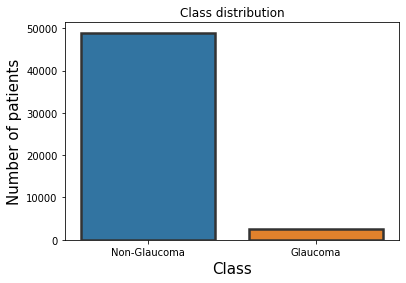

In [22]:
import seaborn as sns

class_name = ['Non-Glaucoma', 'Glaucoma']
count = [n_NG, n_G]
# plt.bar(class_name, count)
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of patients', fontsize=15)
plt.title('Class distribution')
plt.show()

## Class weights for imbalance data set to use in Random forest classifier
Class weight is selected based on experimentation - ratio almost equivalent to ratio of class distribution.

In [23]:
class_weight = dict({0:1, 1:35})

## Feature Reduction and Saving Dataframe with reduced features
The features which implied glaucoma directly have been removed - **cols2rem**

Rest of the columns are checked for which ones have higher importance in glaucoma detection

In [10]:
# cols2rem = ['87-','92-','135-','2227-','4689-','5181-','5326-','5327-','5945-','6119-','6148-','20002-','20008-','20009-','20010-','20011','20013-',
#             '20014-','40001-','40002-','41078-','41080-','41082-','41083-','41084-','41096-','41101-','41142-','41202-','41204-',
#             '41200-','41210-']

# # len(cols2rem) # 13
# remove_df  = enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[0])]
# for i in range(1,len(cols2rem)):
#     remove_df = remove_df.join(enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[i])])
    
# new_enc_df = enc_df.drop(remove_df.columns, axis=1)
# new_enc_df.shape

### Spliting new_enc_df to train test val as per the indices - SAVED - hence code is commented out
The new_enc_df created after removing the obvious columns, is then divided into train-val-test sets using respective indices

In [11]:
# meta_train = []
# meta_val = []
# meta_test = []

# for i in range(len(indices_train)):
#     meta_train.append(new_enc_df.iloc[indices_train[i]])
    
# for i in range(len(indices_val)):
#     meta_val.append(new_enc_df.iloc[indices_val[i]])
#     meta_test.append(new_enc_df.iloc[indices_test[i]])

# meta_train_arr = np.asarray(meta_train)
# meta_val_arr = np.asarray(meta_val)
# meta_test_arr = np.asarray(meta_test)

# meta_train_df = pd.DataFrame(meta_train_arr,columns = new_enc_df.columns)
# meta_val_df = pd.DataFrame(meta_val_arr,columns = new_enc_df.columns)
# meta_test_df = pd.DataFrame(meta_test_arr,columns = new_enc_df.columns)

Saved so that the entire time consuming process is not repeated again

In [12]:
# #SAVE - DONE
# meta_train_df.to_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
# meta_val_df.to_pickle(tts_path + 'reducedfeatures_meta_val.pkl')
# meta_test_df.to_pickle(tts_path + 'reducedfeatures_meta_test.pkl')

### Loading Reduced Features Encodeded Metadata - Train and Validation

In [24]:
meta_train_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
meta_val_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_val.pkl')
meta_test_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_test.pkl')

meta_train_df.shape, meta_val_df.shape, meta_test_df.shape, len(y_train), len(y_val), len(y_test)

((51438, 4898), (17146, 4898), (17146, 4898), 51438, 17146, 17146)

## RandomForestClassifier for Feature Importance

#### 1. Without class weights - everything is classified as majority class - High accuracy but 0 precision and recall
This code is commented out since we go with the classifier with class weights to obtain feature importance.

In [15]:
# # # Random forest classifier
# rfc_all = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
# rfc_all.fit(meta_train_df, y_train)

#### 2. With class weights - giving higher weight to minority class
To reduce the bias towards majority class

In [25]:
rfc_all_cw = RandomForestClassifier(bootstrap=True,
                                    class_weight=class_weight, criterion='gini',
                                    max_depth=8, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=4, min_samples_split=10,
                                    min_weight_fraction_leaf=0.0, n_estimators=300,
                                    n_jobs=-1, oob_score=True,
                                    verbose=0, warm_start=False)

In [26]:
rfc_all_cw.fit(meta_train_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 35},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

### Feature Dictionaries
Dictionary of all the disease codes and their respective names 

In [27]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [28]:
# Random forest is used to get the importance values of each of the feature columns
feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_all_cw, meta_train_df)

In [29]:
pd.options.display.max_colwidth = 100

fi_red = get_imp_features(50)
display_all(fi_red)

,Features,Importance
0,Taking other prescription medications,0.014826
1,Year of birth,0.012486
2,"Intra-ocular pressure, Goldmann-correlated (right)",0.010625
3,Intra-ocular pressure device ID (left),0.009749
4,Age when attended assessment centre,0.008387
5,"Intra-ocular pressure, Goldmann-correlated (left)",0.008227
6,"Intra-ocular pressure, corneal-compensated (right)",0.007645
7,Overall health rating,0.006604
8,Forced expiratory volume in 1-second (FEV1),0.005226
9,"Long-standing illness, disability or infirmity",0.005170


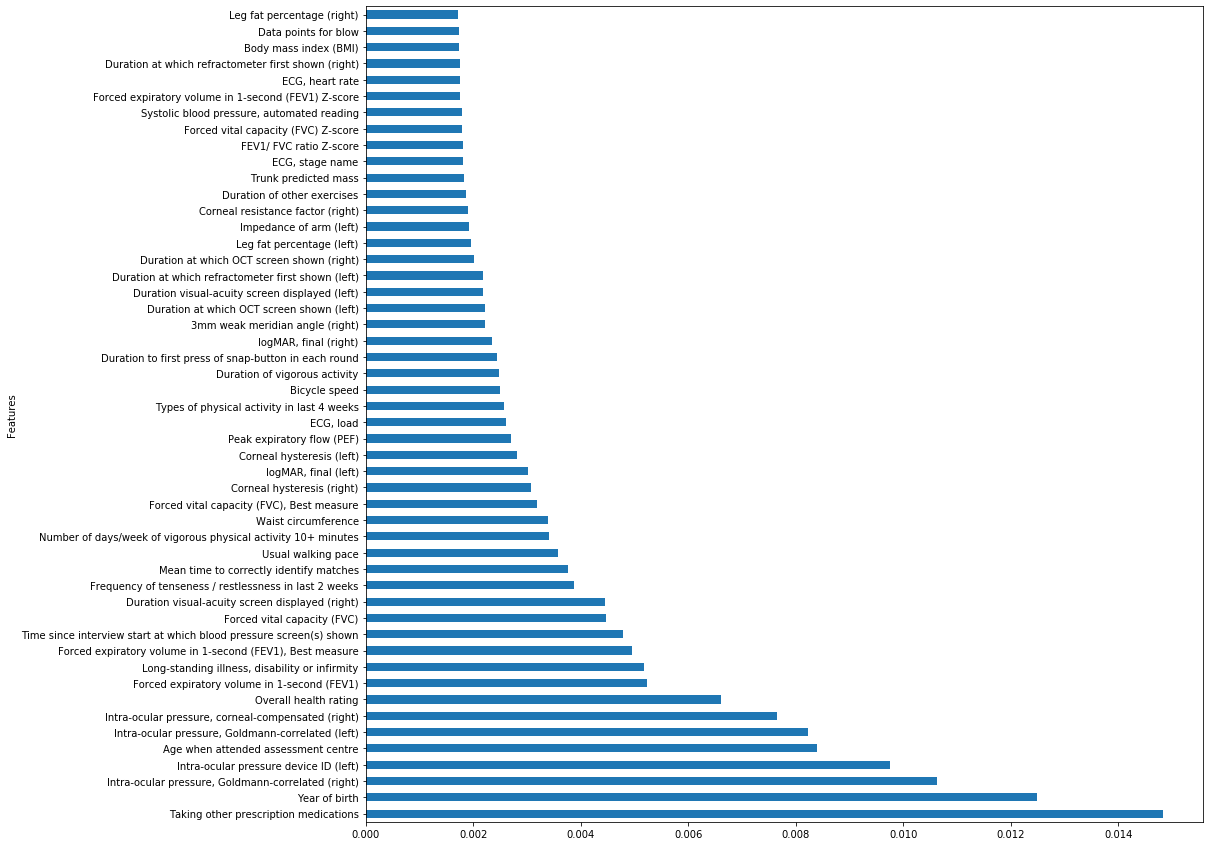

In [30]:
def plot_fi(finew):
    return finew.plot('Features','Importance','barh',figsize=(15,15),legend=False)

plot_fi(fi_red)

## Creating Dataframe containing important features
Taking a particular threshold from above figure to get the first few most important features only

In [31]:
# Getting feature from feature description
feat_to_keep = fi_red[fi_red.Importance>0.0005].Features # threshold : 0.0005
featval_to_keep = []
for i in range(len(feat_to_keep)):
    for feat, desc in feat_unique_dict.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if desc == feat_to_keep[i]:
            featval_to_keep.append(feat)
            break
            
len(featval_to_keep) # unique features having importance > threshold.

50

In [32]:
meta_train_df.shape, meta_val_df.shape, meta_test_df.shape

((51438, 4898), (17146, 4898), (17146, 4898))

In [68]:
# Creating TRAIN dataframe with only the important features

redtrain_df = meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[0]+'-')]
for i in range(1,len(featval_to_keep)):
    redtrain_df = redtrain_df.join(meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[i]+'-')])
    
redtrain_df.shape

(51438, 621)

In [69]:
# Creating VALIDATION dataframe with only the important features

redval_df = meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[0]+'-')]
for i in range(1,len(featval_to_keep)):
    redval_df = redval_df.join(meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[i]+'-')])
    
redval_df.shape

(17146, 621)

In [70]:
# Creating TEST dataframe with only the important features

redtest_df = meta_test_df.loc[:,meta_test_df.columns.str.startswith(featval_to_keep[0]+'-')]
for i in range(1,len(featval_to_keep)):
    redtest_df = redtest_df.join(meta_test_df.loc[:,meta_test_df.columns.str.startswith(featval_to_keep[i]+'-')])
    
redtest_df.shape

(17146, 621)

#### without class_weight
Commented out as we train a classifier with class weights.


In [31]:

# rfc_red = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
# rfc_red.fit(redtrain_df, y_train)

#### with class weight

In [71]:
rfc_red_cw = RandomForestClassifier(bootstrap=True,
                                    class_weight=class_weight, criterion='gini',
                                    max_depth=8, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=4, min_samples_split=10,
                                    min_weight_fraction_leaf=0.0, n_estimators=300,
                                    n_jobs=-1, oob_score=True,
                                    verbose=0, warm_start=False)

rfc_red_cw.fit(redtrain_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 35},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

### Loading Reduced features random forest

In [72]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [73]:
# Plotting the important features only to see the correlation between the features

feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_red_cw, redtrain_df)
fi_red = get_imp_features(40)
display_all(fi_red)

,Features,Importance
0,Taking other prescription medications,0.030413
1,"Intra-ocular pressure, Goldmann-correlated (right)",0.024139
2,Age when attended assessment centre,0.023092
3,Year of birth,0.022773
4,"Intra-ocular pressure, Goldmann-correlated (left)",0.021815
5,"Intra-ocular pressure, corneal-compensated (right)",0.020529
6,Overall health rating,0.013157
7,Time since interview start at which blood pressure screen(s) shown,0.012539
8,"Forced expiratory volume in 1-second (FEV1), Best measure",0.011300
9,Forced expiratory volume in 1-second (FEV1),0.010952


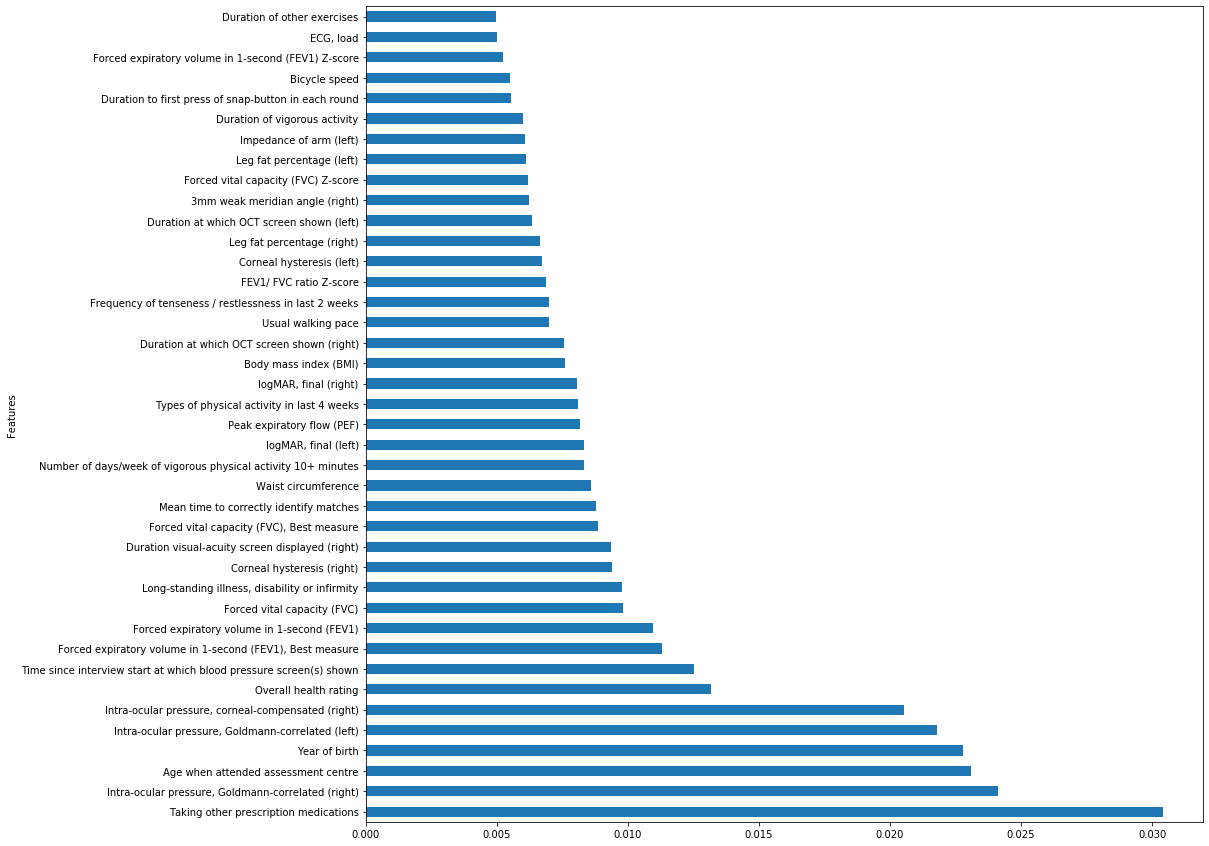

In [74]:
plot_fi(fi_red)

## Compare The Accuracy Of Full Feature Classifier To Limited Feature Classifier


In [75]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix

# Full Featured Classifier To The Test Data
y_pred = rfc_all_cw.predict(meta_val_df) # prediction using all features
y_important_pred = rfc_red_cw.predict(redval_df) # prediction using important features only

In [76]:
all_pred_train = rfc_all_cw.predict(meta_train_df) # train
all_pred_val = rfc_all_cw.predict(meta_val_df) # validation
all_pred_test = rfc_all_cw.predict(meta_test_df) # test

In [78]:
# No. of features reduced from 4898 to 621

meta_val_df.shape, redval_df.shape

((17146, 4898), (17146, 621))

#### F1 score

In [79]:
# 40 features
f1_score(y_val, y_pred) , f1_score(y_val, y_important_pred)

(0.1293401965372017, 0.13264711594484366)

#### Accuracy score

In [80]:
accuracy_score(y_val, y_pred) , accuracy_score(y_val, y_important_pred)

(0.4574244721801003, 0.4790621719351452)

#### Recall score

In [81]:
recall_score(y_val, y_pred) , recall_score(y_val, y_important_pred)

(0.8110328638497653, 0.8016431924882629)

#### Precision score

In [82]:
precision_score(y_val, y_pred) , precision_score(y_val, y_important_pred)

(0.07027356859554561, 0.07230573787846707)

#### classification_report

In [83]:
print(classification_report(y_val, y_pred) ,"\n\n", classification_report(y_val, y_important_pred))

              precision    recall  f1-score   support

           0       0.98      0.44      0.61     16294
           1       0.07      0.81      0.13       852

    accuracy                           0.46     17146
   macro avg       0.52      0.62      0.37     17146
weighted avg       0.93      0.46      0.58     17146
 

               precision    recall  f1-score   support

           0       0.98      0.46      0.63     16294
           1       0.07      0.80      0.13       852

    accuracy                           0.48     17146
   macro avg       0.53      0.63      0.38     17146
weighted avg       0.93      0.48      0.60     17146



#### Confusion matrix

In [84]:
# tn, fp, fn, tp
print(confusion_matrix(y_val, y_pred) ,"\n\n", confusion_matrix(y_val, y_important_pred))

[[7152 9142]
 [ 161  691]] 

 [[7531 8763]
 [ 169  683]]


Healthy Patients - correctly identified (True Negatives):  7152 0.4389345771449613
Healthy Patients - predicted to have glaucoma (False Positives):  9142 0.5610654228550387
Glaucoma Patients - predicted healthy (False Negatives):  161 0.18896713615023475
Glaucoma Patients - correctly identified (True Positives):  691 0.8110328638497653

Total Glaucoma patients:  852 1.0
Total Healthy patients:  16294 1.0


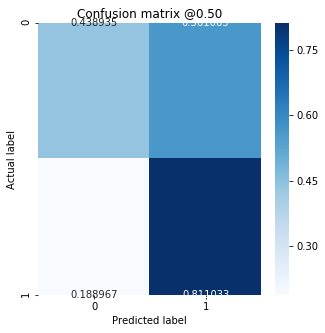

In [85]:
plot_cm(y_val, y_pred)

Healthy Patients - correctly identified (True Negatives):  7531 0.4621946728857248
Healthy Patients - predicted to have glaucoma (False Positives):  8763 0.5378053271142752
Glaucoma Patients - predicted healthy (False Negatives):  169 0.1983568075117371
Glaucoma Patients - correctly identified (True Positives):  683 0.8016431924882629

Total Glaucoma patients:  852 1.0
Total Healthy patients:  16294 1.0


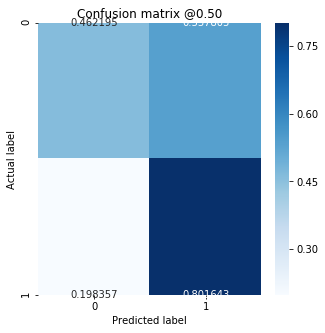

In [86]:
plot_cm(y_val, y_important_pred)

In [87]:
get_metrics(y_train, y_val, y_test, all_pred_train, all_pred_val, all_pred_test)

Metrics:		Train:			Validation:		Test:
Accuracy:	 0.4742602745052296 	 0.4574244721801003 	 0.4558497608771725
Recall:		 0.9692737430167597 	 0.8110328638497653 	 0.7912621359223301
Precision:	 0.08263310086749447 	 0.07027356859554561 	 0.06646279306829765
F1 score:	 0.152283627472493 	 0.1293401965372017 	 0.12262554071845025
AUC:		 0.7090912163134154 	 0.6249837204973633 	 0.6150894676670834


## Creating and saving Dataframe containing final 40 features only
Saved to be used in a multimodal model

In [88]:
# Getting feature from feature description
feat_to_keep = fi_red.Features
featval_to_keep = []
for i in range(len(feat_to_keep)):
    for feat, desc in feat_unique_dict.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if desc == feat_to_keep[i]:
            featval_to_keep.append(feat)
            break
            
len(featval_to_keep)

40

In [94]:
redtrain_df = meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[0]+'-')]
for i in range(1,len(featval_to_keep)):
    redtrain_df = redtrain_df.join(meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[i]+'-')])
    
redtrain_df.shape

(51438, 621)

In [97]:
redval_df = meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[0]+'-')]
for i in range(1,len(featval_to_keep)):
    redval_df = redval_df.join(meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[i]+'-')])
    
redval_df.shape

(17146, 621)

In [98]:
redtest_df = meta_test_df.loc[:,meta_test_df.columns.str.startswith(featval_to_keep[0]+'-')]
for i in range(1,len(featval_to_keep)):
    redtest_df = redtest_df.join(meta_test_df.loc[:,meta_test_df.columns.str.startswith(featval_to_keep[i]+'-')])
    
redtest_df.shape

(17146, 621)

In [99]:
redtrain_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df_FINAL.pkl')
redval_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df_FINAL.pkl')
redtest_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_test_df_FINAL.pkl')

## Loading

In [100]:
# LOAD
final_redtrain_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df_FINAL.pkl')
final_redval_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df_FINAL.pkl')
final_redtest_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_test_df_FINAL.pkl')
final_redtrain_df.shape, final_redval_df.shape, final_redtest_df.shape

((51438, 621), (17146, 621), (17146, 621))

## FINAL Performance on using important features only

In [101]:
rfc_imp = RandomForestClassifier(bootstrap=True,
                                class_weight=class_weight, criterion='gini',
                                max_depth=8, max_features='auto', max_leaf_nodes=None,
                                min_impurity_decrease=0.0, min_impurity_split=None,
                                min_samples_leaf=4, min_samples_split=10,
                                min_weight_fraction_leaf=0.0, n_estimators=300,
                                n_jobs=-1, oob_score=True,
                                verbose=0, warm_start=False)

rfc_imp.fit(final_redtrain_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 35},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [102]:
# True Values: y_train, y_val, y_test

#Predicted Values
imp_train_pred = rfc_imp.predict(final_redtrain_df)
imp_val_pred = rfc_imp.predict(final_redval_df)
imp_test_pred = rfc_imp.predict(final_redtest_df)


In [103]:
get_metrics(y_train, y_val, y_test, imp_train_pred, imp_val_pred, imp_test_pred)

Metrics:		Train:			Validation:		Test:
Accuracy:	 0.491134958590925 	 0.4749795870757028 	 0.4747462965123061
Recall:		 0.9509177972865124 	 0.8133802816901409 	 0.7839805825242718
Precision:	 0.08380516968524705 	 0.07267197986577181 	 0.06818661600168884
F1 score:	 0.15403509905950033 	 0.1334231805929919 	 0.12546125461254612
AUC:		 0.7092527349875708 	 0.6353325859168761 	 0.6215577462308897


Healthy Patients - correctly identified (True Negatives):  22880 0.4675876726886291
Healthy Patients - predicted to have glaucoma (False Positives):  26052 0.5324123273113709
Glaucoma Patients - predicted healthy (False Negatives):  123 0.04908220271348763
Glaucoma Patients - correctly identified (True Positives):  2383 0.9509177972865124

Total Glaucoma patients:  2506 1.0
Total Healthy patients:  48932 1.0


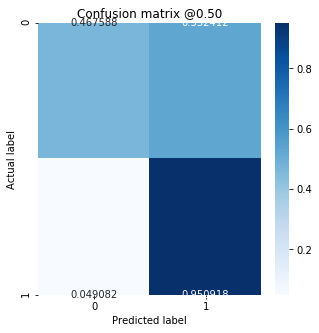

In [104]:
plot_cm(y_train, imp_train_pred)

Healthy Patients - correctly identified (True Negatives):  7451 0.4572848901436111
Healthy Patients - predicted to have glaucoma (False Positives):  8843 0.5427151098563888
Glaucoma Patients - predicted healthy (False Negatives):  159 0.18661971830985916
Glaucoma Patients - correctly identified (True Positives):  693 0.8133802816901409

Total Glaucoma patients:  852 1.0
Total Healthy patients:  16294 1.0


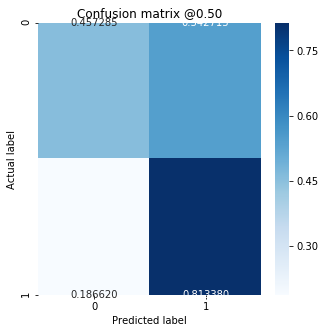

In [105]:
plot_cm(y_val, imp_val_pred)

Healthy Patients - correctly identified (True Negatives):  7494 0.45913490993750766
Healthy Patients - predicted to have glaucoma (False Positives):  8828 0.5408650900624924
Glaucoma Patients - predicted healthy (False Negatives):  178 0.21601941747572814
Glaucoma Patients - correctly identified (True Positives):  646 0.7839805825242718

Total Glaucoma patients:  824 1.0
Total Healthy patients:  16322 1.0


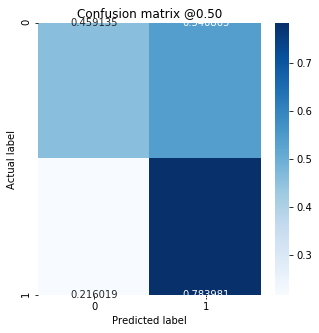

In [106]:
plot_cm(y_test, imp_test_pred)